<a href="https://colab.research.google.com/github/oscarserc/TESIS_Transformers/blob/main/1a_Practica_MNIST_TRANSFORMERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Empezamos con la clasificación MNIST sin emplear mecanismos de atención, sólo empleamos los módulos **Pytorch_Lightning**.

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 919 kB 25.4 MB/s 
     |████████████████████████████████| 636 kB 57.8 MB/s 
     |████████████████████████████████| 829 kB 61.9 MB/s 
     |████████████████████████████████| 119 kB 66.8 MB/s 
     |████████████████████████████████| 282 kB 27.2 MB/s 
     |████████████████████████████████| 1.3 MB 65.5 MB/s 
     |████████████████████████████████| 294 kB 59.7 MB/s 
     |████████████████████████████████| 142 kB 61.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d7cd5f2b08484bd2e78879f3aa9cfe90fd0cef4b2cec3b86bce74632bc030ede
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

In [ ]:
# CARGAMOS LAS LIBRERÍAS
# ======================

import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
# CLASES para la CARGA DE DATOS (convertir en tensores y crear el DataLoader)
# =============================

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int = 64, Dataset = Dataset):
    super().__init__() 
    self.batch_size = batch_size
    self.Dataset = Dataset

  def setup(self, stage=None):
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist['data'], mnist['target']
    X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
    self.train_ds = self.Dataset(X_train, y_train)
    self.val_ds = self.Dataset(X_test, y_test)

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size)


In [ ]:
# INSTANCIAMOS LA CLASE PIRNCIPAL (y pasamos unos valores de prueba)
# ===============================

dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

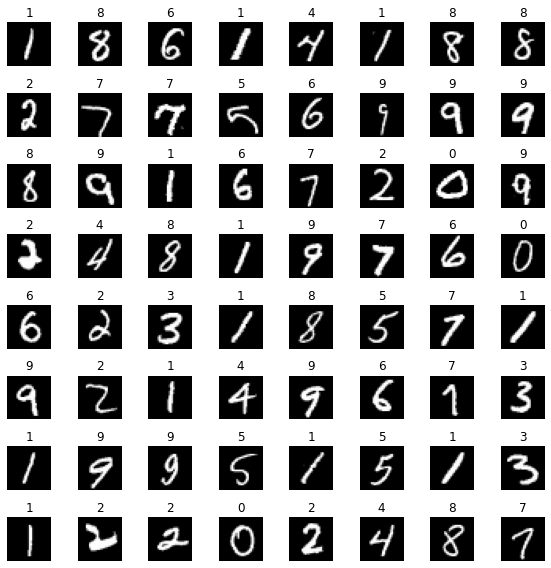

In [ ]:
# REPRESENTAMOS GRÁFICAMENTE ALGUNOS VALORES DE LA BASE DE DATOS
# ==============================================================

r, c = 8, 8
fig = plt.figure(figsize=(c, r))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(label.item())
plt.tight_layout()
plt.show()


In [ ]:
# PROCEDEMOS A CREAR UN MODELO y a ENTRENARLO
# ===========================================

class MLP(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(784, 784),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(784, 10),
    )

  def forward(self, x):
    return self.mlp(x)

  def predict(self, x):
    with torch.no_grad():
      y_hat = self(x)
      return torch.argmax(y_hat, axis=1)

  def compute_loss_and_acc(self, batch):
    x, y  = batch
    y_hat = self(x)
    loss  = F.cross_entropy(y_hat, y)
    acc   = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('loss', loss)
    self.log('acc' , acc, prog_bar=True)
    return loss        

  def validation_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc' , acc , prog_bar=True)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
    return optimizer  


In [ ]:
# INSTANCIAMOS EL MODELO (y proporcionamos un valor de prueba)
# ======================

mlp = MLP()
output = mlp(torch.randn(64, 784))
output.shape

torch.Size([64, 10])

In [ ]:
# ENTRENAMOS EL MODELO
# ====================

mlp = MLP()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(mlp, dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

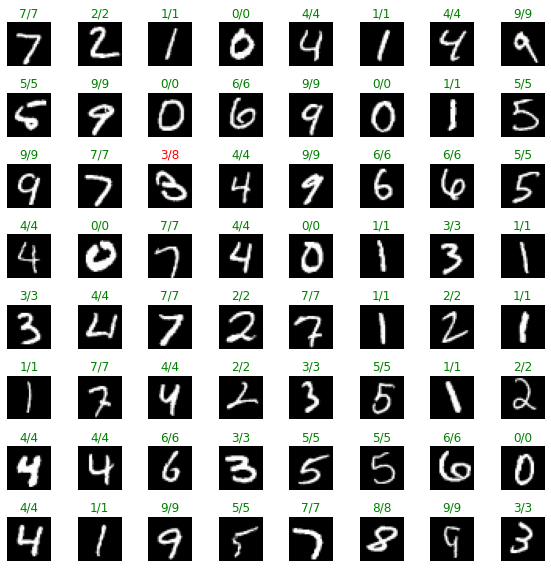

In [ ]:
# REPRESENTAMOS ALGUNOS VALORES
# =============================

imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c,r))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f'{label.item()}/{preds[ix].item()}', color='green' if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()    



# AHORA UTILIZAMOS **MECANISMOS DE ATENCIÓN**

In [ ]:
# CREAMOS UNA CLASE QUE:
# · Maneja los DATOS
# · Crea los PATCHES de las imágenes
# ==================================

class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7,7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28,28)
    h, w  = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w)
    patches = patches.contiguous().view(-1, h*w)
    return patches, torch.tensor(self.y[ix]).long()    

In [ ]:
# INSTANCIAMOS Y PASAMOS UNOS VALORES DE PRUEBA
# =============================================

attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 16, 49]), torch.Size([64]))

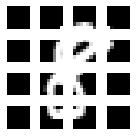

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ======================

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(2,2))
for i in range(4):
  for j in range(4):
    ax = plt.subplot(4, 4, i*4 + j + 1)
    ax.imshow(imgs[6, i*4 + j].view(7,7), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()



In [ ]:
# IMPLEMENTAMOS EL MECANISMO DE ATENCIÓN: ScaleDotSelfAttention
# ======================================

import math

class ScaleDotSelfAttention(torch.nn.Module):
  def __init__(self, n_embd):
    super().__init__()

    self.key   = torch.nn.Linear(n_embd, n_embd)  
    self.query = torch.nn.Linear(n_embd, n_embd)
    self.value = torch.nn.Linear(n_embd, n_embd)

  def forward(self, x):
    B, L, F = x.size()

    k = self.key(x)
    q = self.query(x)
    v = self.value(x)

    att = (q @ k.transpose(1,2))*(1.0 / math.sqrt(k.size(-1)))
    att = torch.nn.functional.softmax(att, dim=-1)
    y   = att @ v

    return y


class Model(MLP):
  def __init__(self, n_embd=7*7, seq_len=4*4):
    super().__init__()
    self.mlp = None

    self.attn = ScaleDotSelfAttention(n_embd)
    self.actn = torch.nn.ReLU(inplace=True)
    self.fc   = torch.nn.Linear(n_embd*seq_len, 10)

  def forward(self, x):
    x = self.attn(x)
    y = self.fc(self.actn(x.view(x.size(0), -1)))
    return y



In [ ]:
# INSTANCIAMOS EL MODELO Y LO ENTRENAMOS
# ======================================

model   = Model()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, attn_dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type                  | Params
-----------------------------------------------
0 | attn | ScaleDotSelfAttention | 7.4 K 
1 | actn | ReLU                  | 0     
2 | fc   | Linear                | 7

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]